In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import calendar
import sys
sys.path.append('../')  # Add the parent folder to the Python path

from sql_functions import get_dataframe  # Import the function

main_cities = [
    "New York, NY",
    "Boston, MA",
    "Washington, DC",
    "Newark, NJ",
]

side_cities = [
    "Miami, FL",
    "Houston, TX",
    "San Francisco, CA",
    "Seattle, WA"
]


In [44]:
flights_2015 = get_dataframe("SELECT * FROM group3.flights_2015 f WHERE month = 12 AND cancellation_code = 'B';")
flights_2017 = get_dataframe("SELECT * FROM group3.flights_2017 f WHERE month = 1 AND cancellation_code = 'B';")
flights_2016 = get_dataframe("SELECT * FROM group3.flights_2016 WHERE cancellation_code = 'B';")

In [145]:
flights_2015['cancelled'] = flights_2015['cancelled'].astype(int)
flights_2016['cancelled'] = flights_2016['cancelled'].astype(int)
flights_2017['cancelled'] = flights_2017['cancelled'].astype(int)



# Concatenando os DataFrames de 2016 e dezembro de 2015
flights_2016_2015 = pd.concat([flights_2015, flights_2016, flights_2017], ignore_index=True)

# Agrupando os dados por ano e mês e calculando o número de voos cancelados e atrasados
monthly_counts = flights_2016_2015.groupby(['year', 'month']).agg({
    'cancelled': 'sum',
    'had_delay': 'sum'
}).reset_index()

monthly_counts

,year,month,cancelled,had_delay
0,2015,12,1060,12
1,2016,1,1641,9
2,2016,2,869,9
3,2016,3,567,8
4,2016,4,419,3
5,2016,5,408,14
6,2016,6,554,10
7,2016,7,790,20
8,2016,8,443,13
9,2016,9,110,6


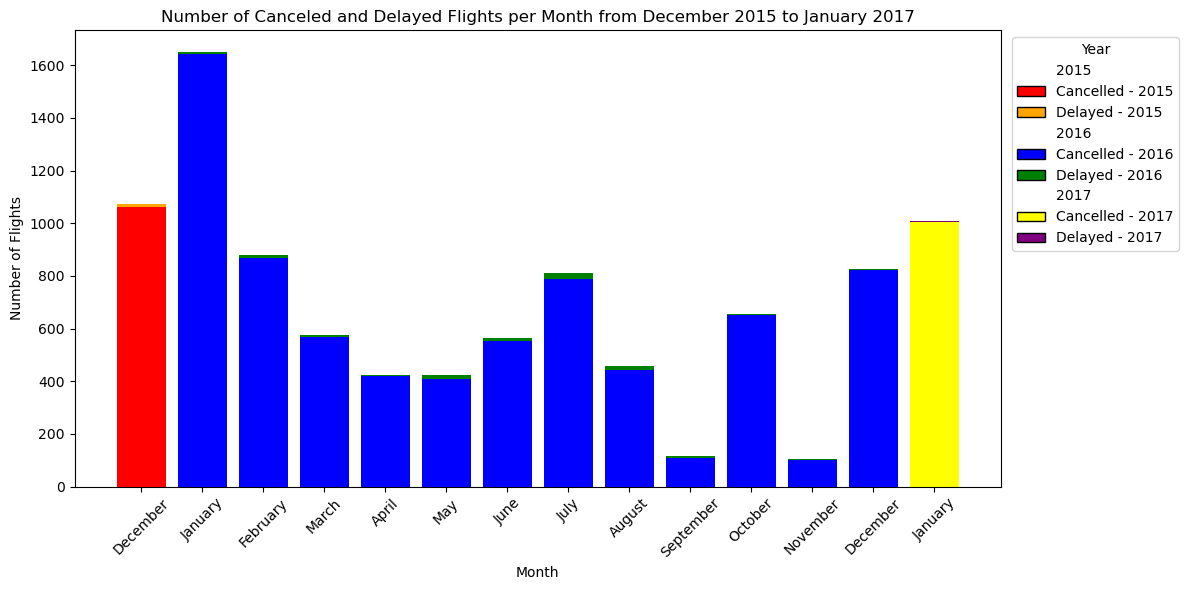

In [105]:
# Mapping month numbers to month names
monthly_counts['month_name'] = monthly_counts['month'].apply(lambda x: calendar.month_name[x])


# Plotting the bar chart
plt.figure(figsize=(12, 6))


# Loop through each row in the DataFrame and plot bars
for index, row in monthly_counts.iterrows():
    year = row['year']
    color_cancelled = 'red' if year == 2015 else ('blue' if year == 2016 else 'yellow')
    color_delay = 'orange' if year == 2015 else ('green' if year == 2016 else 'purple')
    hatch = '\\' if year in [2015, 2016] else None
    plt.bar(index, row['cancelled'], color=color_cancelled, label=f'Cancelled - {year}')
    plt.bar(index, row['had_delay'], bottom=row['cancelled'], color=color_delay, label=f'Delayed - {year}')

# Adding legend for all years
legend_elements = [
    Patch(facecolor='none', edgecolor='none', label='2015'),  # Title for 2015
    Patch(facecolor='red', edgecolor='black', label='Cancelled - 2015'),
    Patch(facecolor='orange', edgecolor='black', label='Delayed - 2015'),
    Patch(facecolor='none', edgecolor='none', label='2016'),  # Title for 2016
    Patch(facecolor='blue', edgecolor='black', label='Cancelled - 2016'),
    Patch(facecolor='green', edgecolor='black', label='Delayed - 2016'),
    Patch(facecolor='none', edgecolor='none', label='2017'),  # Title for 2017
    Patch(facecolor='yellow', edgecolor='black', label='Cancelled - 2017'),
    Patch(facecolor='purple', edgecolor='black', label='Delayed - 2017')
]

plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.2, 1), title='Year')  # Adding legend with titles

plt.title('Number of Canceled and Delayed Flights per Month from December 2015 to January 2017')
plt.xlabel('Month')
plt.ylabel('Number of Flights')
plt.xticks(range(len(monthly_counts)), monthly_counts['month_name'], rotation=45)
plt.tight_layout()
plt.show()

In [148]:
# Assuming monthly_counts is a DataFrame
sum_cancelled_1 = monthly_counts.iloc[12:14]["cancelled"].sum()
sum_cancelled_1 / 2


correlation = monthly_counts['cancelled'].corr(monthly_counts['month'])

print("Correlation coefficient between Column cancelled and Column month:", correlation)

Correlation coefficient between Column cancelled and Column month: -0.38139227273752924


In [149]:
flights_2016

,year,month,day,flight_date,dep_delay,arr_delay,origin,destination,cancelled,cancellation_code,diverted,cancellation_code_info,had_delay
0,2016,1,23,2016-01-23,NaN,None,"Seattle, WA","New York, NY",1,B,0.0,weather conditions,0
1,2016,1,24,2016-01-24,NaN,None,"Seattle, WA","New York, NY",1,B,0.0,weather conditions,0
2,2016,1,25,2016-01-25,NaN,None,"Seattle, WA","New York, NY",1,B,0.0,weather conditions,0
3,2016,1,23,2016-01-23,NaN,None,"New York, NY","Seattle, WA",1,B,0.0,weather conditions,0
4,2016,1,24,2016-01-24,NaN,None,"New York, NY","Seattle, WA",1,B,0.0,weather conditions,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7374,2016,12,12,2016-12-12,NaN,None,"South Bend, IN","Newark, NJ",1,B,0.0,weather conditions,0
7375,2016,12,18,2016-12-18,NaN,None,"South Bend, IN","Newark, NJ",1,B,0.0,weather conditions,0
7376,2016,12,17,2016-12-17,NaN,None,"Chattanooga, TN","Newark, NJ",1,B,0.0,weather conditions,0
7377,2016,12,4,2016-12-04,62.0,None,"Grand Rapids, MI","Newark, NJ",1,B,0.0,weather conditions,0
